In [2]:
# Install any missing packages
!pip install scikit-learn pandas seaborn

Mounting Google Drive...
Mounted at /content/drive
Checking GPU availability...
GPU is available!

Device Information:
- PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Checking dataset at: /content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced

Checking train directory:
  OverRipe: 1300 images
  Ripe: 1300 images
  Unripe: 1300 images
  VeryRipe: 1300 images
Total train images: 5200

Checking valid directory:
  OverRipe: 280 images
  Ripe: 280 images
  Unripe: 280 images
  VeryRipe: 280 images
Total valid images: 1120

Checking test directory:
  OverRipe: 280 images
  Ripe: 280 images
  Unripe: 280 images
  VeryRipe: 280 images
Total test images: 1120

=== Training Random Forest Classifier ===
Creating data generators...
Found 5200 images belonging to 4 classes.
Found 1120 images belonging to 4 classes.
Found 1120 images belonging to 4 classes.
Extracting features from images...
Extracting

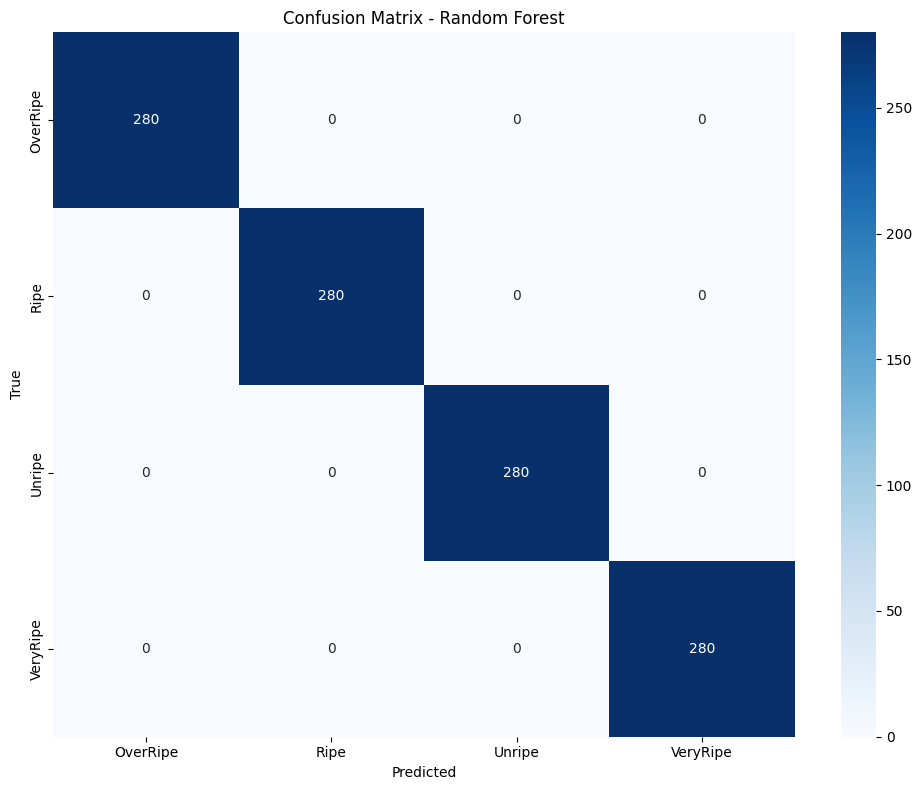

<ipython-input-4-ffa4aa822231>:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


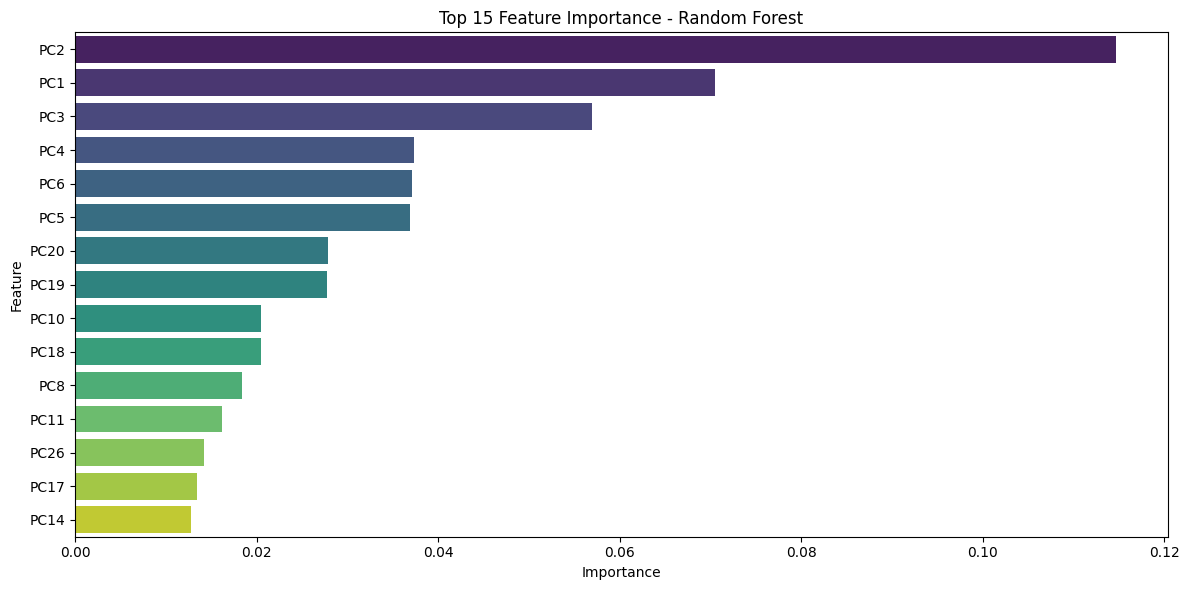

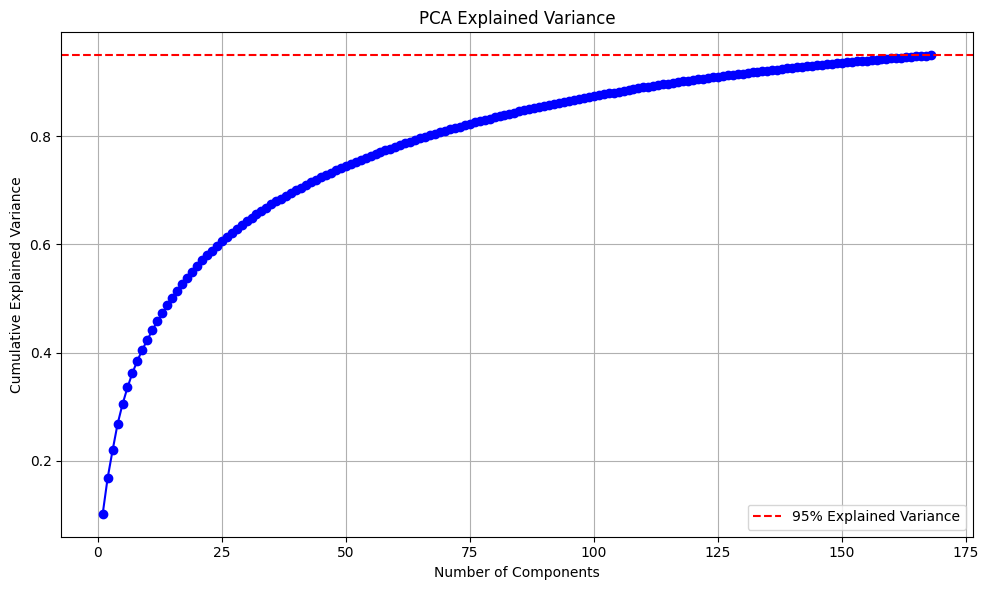

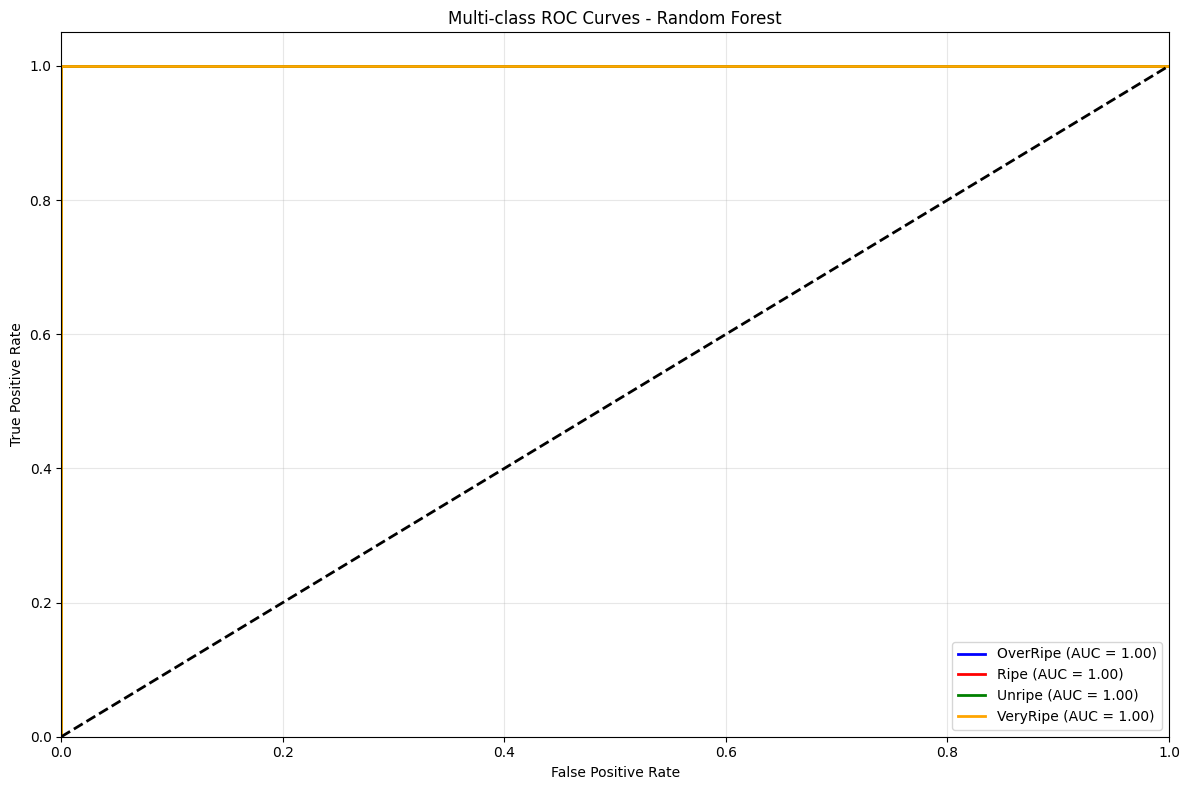


Generating t-SNE visualization...


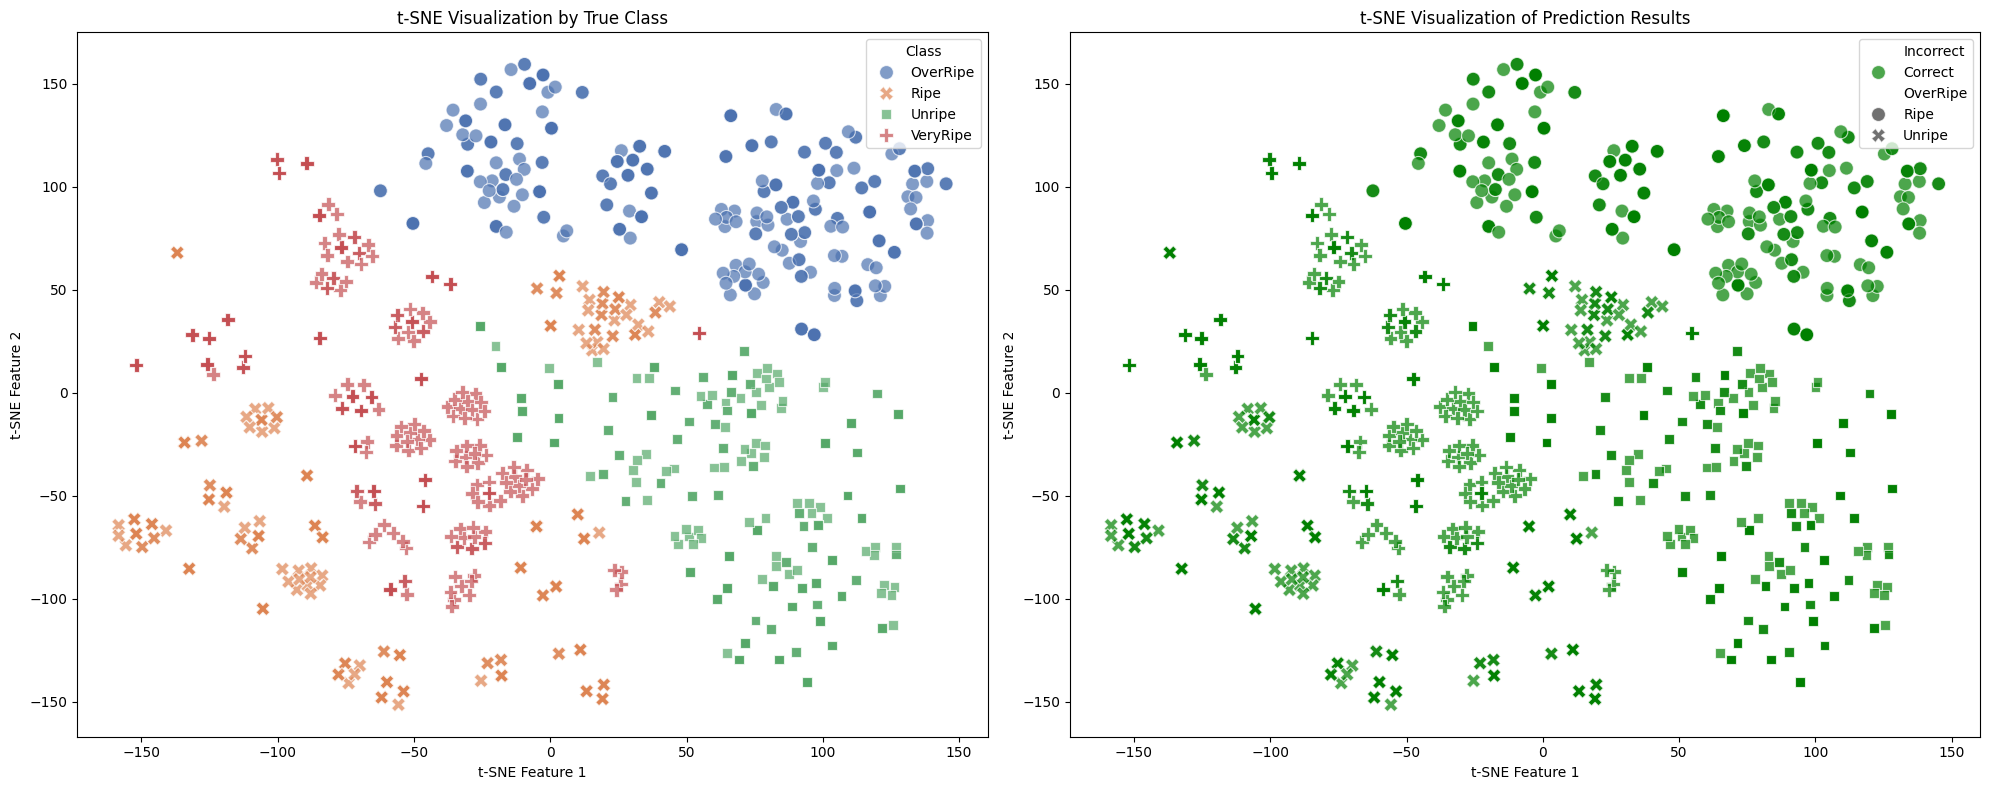

<Figure size 1200x800 with 0 Axes>

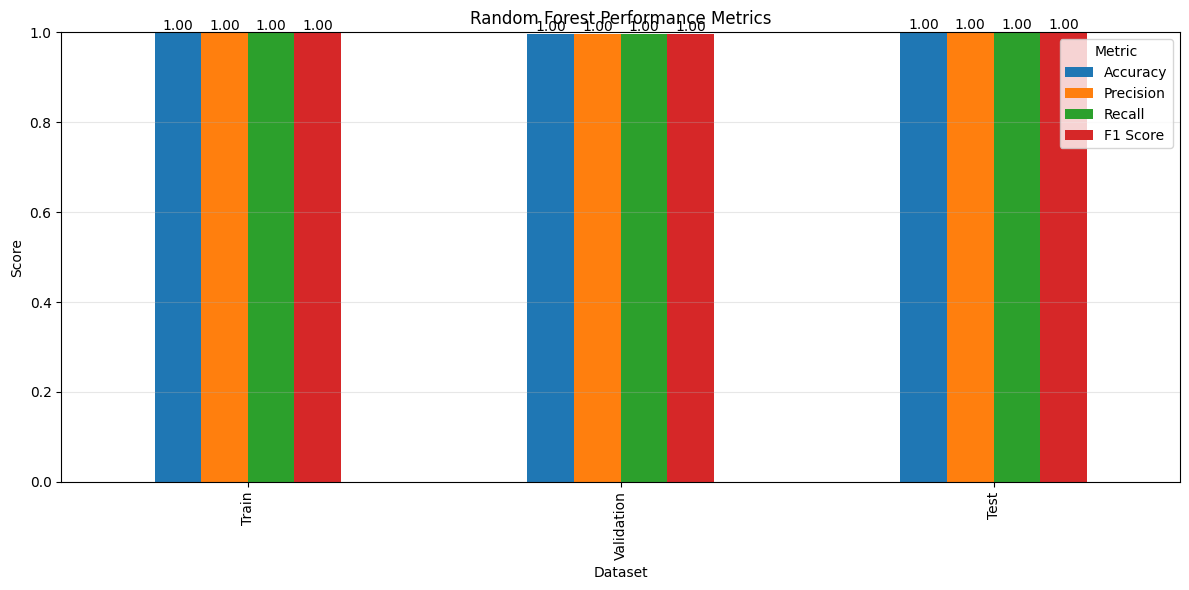

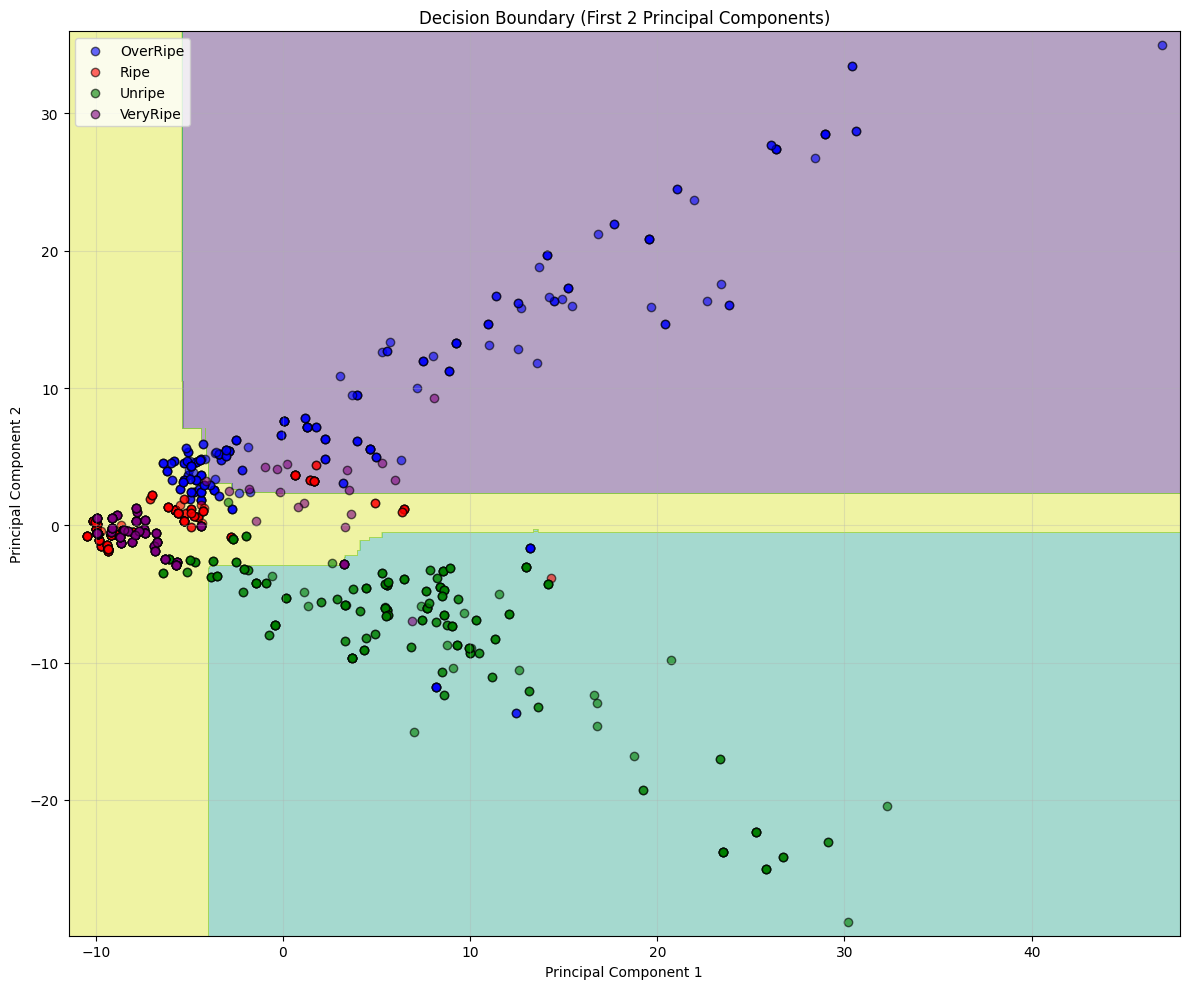


Training completed in 4093.95 seconds
Random Forest training and evaluation complete!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.manifold import TSNE
import time
import tensorflow as tf
from google.colab import drive

def mount_drive():
    """
    Mount Google Drive for Colab access
    Returns:
        None
    """
    print("Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=True)

def verify_gpu():
    """
    Verify GPU availability and print device information
    Returns:
        bool: True if GPU is available, False otherwise
    """
    print("Checking GPU availability...")
    gpu_devices = tf.config.list_physical_devices('GPU')
    if gpu_devices:
        print("GPU is available!")
        print("\nDevice Information:")
        for device in tf.config.list_physical_devices():
            print(f"- {device}")
        # Enable memory growth for GPU
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        return True
    else:
        print("WARNING: No GPU found. Training will be slower on CPU.")
        return False

def verify_dataset_path(base_path):
    """
    Verify dataset structure and print statistical summary

    Args:
        base_path (str): Root path of the dataset

    Returns:
        dict: Dataset statistics including image counts per category
    """
    print(f"\nChecking dataset at: {base_path}")

    categories = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']
    splits = ['train', 'valid', 'test']

    dataset_stats = {}
    total_images = 0

    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            os.makedirs(split_path)
            print(f"Created directory: {split_path}")

        print(f"\nChecking {split} directory:")
        split_stats = {}
        split_total = 0

        for category in categories:
            category_path = os.path.join(split_path, category)
            if not os.path.exists(category_path):
                os.makedirs(category_path)
                print(f"Created directory: {category_path}")

            num_images = len([f for f in os.listdir(category_path)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            split_stats[category] = num_images
            split_total += num_images
            print(f"  {category}: {num_images} images")

        dataset_stats[split] = split_stats
        total_images += split_total
        print(f"Total {split} images: {split_total}")

    if total_images == 0:
        raise ValueError("No images found in the dataset. Please ensure images are properly placed in the directory structure.")

    return dataset_stats

def random_forest_train(base_path, n_trees=200, max_depth=None):
    """
    Train a Random Forest classifier on the mango dataset with enhanced visualizations

    Args:
        base_path (str): Dataset root path
        n_trees (int): Number of trees in the forest
        max_depth (int): Maximum depth of trees

    Returns:
        tuple: (model, features, labels, feature_names)
    """
    print("\n=== Training Random Forest Classifier ===")
    start_time = time.time()

    # Define image size and categories
    img_size = (224, 224)
    categories = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']

    # Prepare data generators without augmentation (for feature extraction)
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

    # Create generators for feature extraction
    print("Creating data generators...")
    train_generator = datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,  # Important for keeping track of labels
        classes=categories
    )

    valid_generator = datagen.flow_from_directory(
        os.path.join(base_path, 'valid'),
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        classes=categories
    )

    test_generator = datagen.flow_from_directory(
        os.path.join(base_path, 'test'),
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        classes=categories
    )

    # Feature extraction using a pre-trained model
    print("Extracting features from images...")
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'  # Global average pooling for feature extraction
    )

    # Extract features and labels - FIXED METHOD
    def extract_features_labels(generator):
        features = []
        labels = []

        # Get the total number of samples
        num_samples = generator.samples
        num_batches = int(np.ceil(num_samples / generator.batch_size))

        # Reset the generator internal index
        generator.reset()

        for i in range(num_batches):
            print(f"\rExtracting batch {i+1}/{num_batches}", end="")

            # Get the next batch - Using generator's internal methods
            batch = next(generator)
            x_batch, y_batch = batch

            # Extract features using the model
            batch_features = base_model.predict(x_batch, verbose=0)

            # Store
            features.append(batch_features)
            labels.append(y_batch)

        print()  # New line after progress

        # Concatenate batches
        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Ensure we only take valid samples (in case the last batch was partially filled)
        features = features[:num_samples]
        labels = labels[:num_samples]

        # Convert one-hot encoded labels to class indices
        labels = np.argmax(labels, axis=1)

        return features, labels

    # Extract features for each set
    train_features, train_labels = extract_features_labels(train_generator)
    valid_features, valid_labels = extract_features_labels(valid_generator)
    test_features, test_labels = extract_features_labels(test_generator)

    # Apply PCA for dimensionality reduction (retain 95% variance)
    print("\nApplying PCA dimensionality reduction...")
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    valid_features_scaled = scaler.transform(valid_features)
    test_features_scaled = scaler.transform(test_features)

    pca = PCA(n_components=0.95)  # Retain 95% of variance
    train_features_pca = pca.fit_transform(train_features_scaled)
    valid_features_pca = pca.transform(valid_features_scaled)
    test_features_pca = pca.transform(test_features_scaled)

    print(f"Original feature dimensions: {train_features.shape[1]}")
    print(f"Reduced feature dimensions: {train_features_pca.shape[1]}")
    print(f"Variance retained: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

    # Create and train the Random Forest model
    print("\nTraining Random Forest Classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1,  # Use all cores
        class_weight='balanced',
        bootstrap=True,
        oob_score=True  # Out-of-bag score
    )

    rf_model.fit(train_features_pca, train_labels)

    # Evaluate on validation set
    valid_predictions = rf_model.predict(valid_features_pca)
    valid_accuracy = accuracy_score(valid_labels, valid_predictions)
    print(f"\nValidation Accuracy: {valid_accuracy:.4f}")
    print(f"Out-of-bag Score: {rf_model.oob_score_:.4f}")

    # Evaluate on test set
    test_predictions = rf_model.predict(test_features_pca)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions,
                              target_names=categories))

    # VISUALIZATION 1: Confusion matrix
    plot_confusion_matrix(test_labels, test_predictions, categories)

    # VISUALIZATION 2: Feature importance
    plot_feature_importance(rf_model, pca, 15)

    # VISUALIZATION 3: ROC curves
    plot_roc_curves(rf_model, test_features_pca, test_labels, categories)

    # VISUALIZATION 4: t-SNE scatter plot
    plot_tsne_scatter(test_features_pca, test_labels, test_predictions, categories)

    # VISUALIZATION 5: Model performance comparison chart
    plot_performance_metrics(rf_model, train_features_pca, train_labels,
                          valid_features_pca, valid_labels,
                          test_features_pca, test_labels)

    # VISUALIZATION 6: Decision boundary visualization (for top 2 PCA components)
    plot_decision_boundary(rf_model, test_features_pca, test_labels, categories)

    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")

    return rf_model, test_features_pca, test_labels, rf_model.feature_importances_

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix for Random Forest results
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Random Forest')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_feature_importance(model, pca, top_n=15):
    """
    Plot feature importance from Random Forest
    """
    # Get feature importance
    importances = model.feature_importances_

    # Create DataFrame for plotting
    feature_names = [f"PC{i+1}" for i in range(len(importances))]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Take top N features
    top_features = importance_df.head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Feature Importance - Random Forest')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Show explained variance by top components
    plt.figure(figsize=(10, 6))
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.savefig('pca_variance.png')
    plt.show()

def plot_roc_curves(model, X_test, y_test, class_names):
    """
    Plot ROC curves for each class
    """
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    # Binarize the labels for multi-class ROC
    y_bin = label_binarize(y_test, classes=range(len(class_names)))

    # Get probability predictions
    y_score = model.predict_proba(X_test)

    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])

    for i, color, cls in zip(range(len(class_names)), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{cls} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves - Random Forest')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves.png')
    plt.show()

def plot_tsne_scatter(features, true_labels, pred_labels, class_names):
    """
    Create a scatter plot visualization using t-SNE
    """
    # Apply t-SNE to reduce dimensionality to 2D for visualization
    print("\nGenerating t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'x': features_2d[:, 0],
        'y': features_2d[:, 1],
        'true_label': [class_names[i] for i in true_labels],
        'pred_label': [class_names[i] for i in pred_labels],
        'correct': true_labels == pred_labels
    })

    # Create two scatter plots: one colored by true labels, one by prediction correctness
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot by true class
    sns.scatterplot(
        x='x', y='y',
        hue='true_label',
        style='true_label',
        palette='deep',
        data=df,
        s=100,
        alpha=0.7,
        ax=ax1
    )
    ax1.set_title('t-SNE Visualization by True Class')
    ax1.set_xlabel('t-SNE Feature 1')
    ax1.set_ylabel('t-SNE Feature 2')
    ax1.legend(title='Class')

    # Plot by prediction correctness
    sns.scatterplot(
        x='x', y='y',
        hue='correct',
        style='true_label',
        palette={True: 'green', False: 'red'},
        data=df,
        s=100,
        alpha=0.7,
        ax=ax2
    )
    ax2.set_title('t-SNE Visualization of Prediction Results')
    ax2.set_xlabel('t-SNE Feature 1')
    ax2.set_ylabel('t-SNE Feature 2')
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles[:5], labels=['Incorrect', 'Correct'] + class_names[:3])

    plt.tight_layout()
    plt.savefig('tsne_visualization.png')
    plt.show()

def plot_performance_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    """
    Plot performance metrics comparison
    """
    from sklearn.metrics import precision_score, recall_score, f1_score

    # Get predictions for all datasets
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'Accuracy': [
            accuracy_score(y_train, train_pred),
            accuracy_score(y_valid, valid_pred),
            accuracy_score(y_test, test_pred)
        ],
        'Precision': [
            precision_score(y_train, train_pred, average='weighted'),
            precision_score(y_valid, valid_pred, average='weighted'),
            precision_score(y_test, test_pred, average='weighted')
        ],
        'Recall': [
            recall_score(y_train, train_pred, average='weighted'),
            recall_score(y_valid, valid_pred, average='weighted'),
            recall_score(y_test, test_pred, average='weighted')
        ],
        'F1 Score': [
            f1_score(y_train, train_pred, average='weighted'),
            f1_score(y_valid, valid_pred, average='weighted'),
            f1_score(y_test, test_pred, average='weighted')
        ]
    }

    # Create DataFrame for plotting
    df_metrics = pd.DataFrame(metrics, index=['Train', 'Validation', 'Test'])

    # Plot
    plt.figure(figsize=(12, 8))
    df_metrics.plot(kind='bar', figsize=(12, 6))
    plt.title('Random Forest Performance Metrics')
    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Metric')
    for container in plt.gca().containers:
        plt.gca().bar_label(container, fmt='%.2f')
    plt.tight_layout()
    plt.savefig('performance_metrics.png')
    plt.show()

def plot_decision_boundary(model, X, y, class_names):
    """
    Plot decision boundary for top 2 principal components
    """
    # Use only the first two dimensions
    X_2d = X[:, :2]

    # Create mesh grid
    h = 0.02  # step size in the mesh
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Create features for prediction (use only first two components)
    features_for_prediction = np.c_[xx.ravel(), yy.ravel()]

    # Pad with zeros to match the original feature dimensions
    padded_features = np.zeros((features_for_prediction.shape[0], X.shape[1]))
    padded_features[:, :2] = features_for_prediction

    # Predict
    Z = model.predict(padded_features)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Plot class samples
    for i, color, label in zip(range(len(class_names)), ['blue', 'red', 'green', 'purple'], class_names):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=color, label=label,
                   edgecolor='black', alpha=0.6)

    plt.title("Decision Boundary (First 2 Principal Components)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('decision_boundary.png')
    plt.show()

def main():
    """Main execution function"""
    try:
        # Set random seeds for reproducibility
        tf.random.set_seed(42)
        np.random.seed(42)

        # Set base path
        base_path = '/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced'

        # Mount Google Drive
        mount_drive()

        # Verify GPU
        verify_gpu()

        # Verify dataset structure
        verify_dataset_path(base_path)

        # Train Random Forest model
        rf_model, test_features, test_labels, feature_importances = random_forest_train(
            base_path,
            n_trees=200,
            max_depth=None  # Use None for unlimited depth or set a value
        )

        print("Random Forest training and evaluation complete!")

    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
